# Importing Libaries

In [0]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from data_cleaning import data_cleaner

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from data_preprocessing import data_preprocessor

from modelling import model_report, mixed_NB, mixed_NB_predict
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import CategoricalNB, GaussianNB

# Data Cleaning

In [0]:
data_cleaner('data/cardio_data.csv', 'data/cardio_data_clean.csv')

In [2]:
cardio_data = pd.read_csv('cardio_data_clean.csv')
cardio_data.head()

,age,gender,blood_pressure_max,blood_pressure_min,cholesterol_level,glucose_level,smoking_status,alcohol_status,activity_level,disease,bmi
0,39,1,110,70,1,1,0,0,1,1,31
1,64,1,120,70,1,1,0,0,1,1,26
2,55,0,140,90,2,2,0,0,1,1,31
3,54,0,130,80,1,3,0,0,1,1,29
4,60,1,120,80,2,2,0,1,1,1,20


# EDA

In [0]:
# EDA.ipynb notebook

# Data Preprocessing

In [0]:
X = cardio_data.drop(columns = ['disease'])
y = cardio_data['disease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

In [0]:
X_train_scaled = data_preprocessor(X_train)
X_test_scaled = data_preprocessor(X_test)

# Modelling

## Logistic Regression

### Training Model

In [0]:
lr = LogisticRegression()
lr_model = lr.fit(X_train_scaled, y_train)

y_test_hat = lr_model.predict(X_test_scaled)
y_test_proba = lr_model.predict_proba(X_test_scaled)[:,1]

### Model Report

Logistic Regression Model Report


- performance metrics (default threshold):

accuracy = 0.731, auc_score = 0.731

precision = 0.758, recall = 0.679, f1-score = 0.716

- ROC curve:



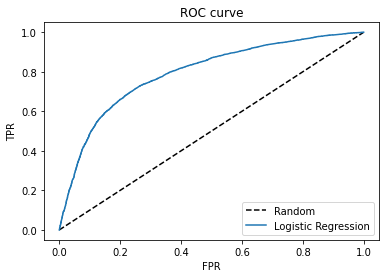


- optimal probability threshold:

0.46

- precision recall tradeoff:



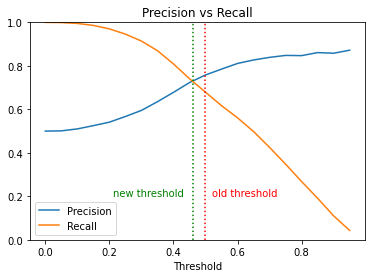


- performance metrics (new threshold):

accuracy = 0.732, auc_score = 0.732

precision = 0.734, recall = 0.728, f1-score = 0.731

- confusion matrix:



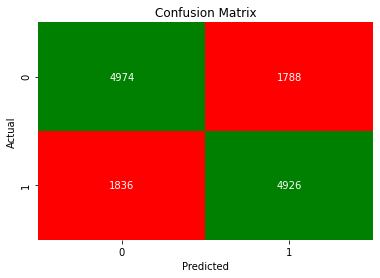

In [10]:
model_report(y_test, y_test_hat, y_test_proba, "Logistic Regression")

### Plotting Coefficients

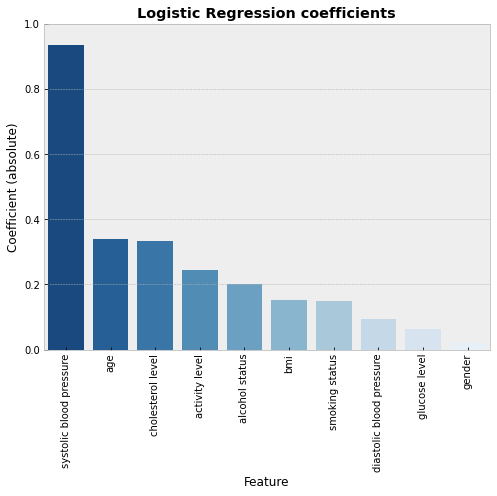

In [13]:
lr_coeffs = pd.DataFrame(list(zip(X_train_scaled.columns, np.absolute(lr_model.coef_[0]))), columns = ['feature', 'coefficient magnitude'])
lr_coeffs_sorted = lr_coeffs.sort_values(by = 'coefficient magnitude', ascending = False)

plt.style.use('bmh')

fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(111)
sns.barplot(data = lr_coeffs_sorted, x = 'feature', y = 'coefficient magnitude', ax = ax, palette = 'Blues_r')
ax.set_title('Logistic Regression coefficients', fontweight = 'bold')
ax.set_xlabel('Feature')
ax.set_ylabel('Coefficient (absolute)')
ax.set_xticklabels(['systolic blood pressure', 'age', 'cholesterol level', 'activity level', 'alcohol status', 'bmi', 'smoking status', 'diastolic blood pressure', 'glucose level', 'gender'])
ax.set_yticks(np.arange(0,1.2,0.2))
plt.xticks(rotation = 90);

## k-Nearest Neighbours

### Training Baseline Model

In [0]:
knn = KNeighborsClassifier()
base_knn_model = knn.fit(X_train_scaled, y_train)

y_test_hat = base_knn_model.predict(X_test_scaled)
y_test_proba = base_knn_model.predict_proba(X_test_scaled)

### Hyperparameter Tuning

#### Tuning k

In [0]:
ks = range(5,105,5)
scores = []
for k in ks:
    knn = KNeighborsClassifier(n_neighbors = k)
    score = np.mean(cross_val_score(knn, X_train_scaled, y_train, scoring = 'roc_auc', cv = 5))
    scores.append(score)

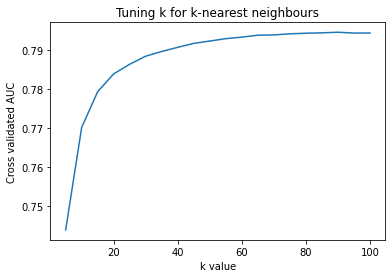

In [9]:
plt.plot(ks, scores)
plt.title('Tuning k for k-nearest neighbours')
plt.xlabel('k value')
plt.ylabel('Cross validated AUC');

#### Tuning distance and weight metrics

In [16]:
param_grid = {'n_neighbors': range(40,120,20), 'weights': ['uniform', 'distance'], 'metric': ['manhattan', 'euclidean']}
knn_gs = GridSearchCV(knn, param_grid, scoring = 'roc_auc', cv = 5, n_jobs = -1)
%time knn_gs.fit(X_train_scaled, y_train)
knn_gs.best_params_

CPU times: user 2.17 s, sys: 120 ms, total: 2.29 s
Wall time: 3min 55s


{'metric': 'manhattan', 'n_neighbors': 100, 'weights': 'uniform'}

### Training Tuned Model

In [0]:
tuned_knn = KNeighborsClassifier(n_neighbors = 100, metric = 'manhattan')
tuned_knn_model = tuned_knn.fit(X_train_scaled, y_train)

y_test_hat = tuned_knn_model.predict(X_test_scaled)
y_test_proba = tuned_knn_model.predict_proba(X_test_scaled)[:,1]

### Model Report

k-Nearest Neighbours Model Report


- performance metrics (default threshold):

accuracy = 0.734, auc_score = 0.734

precision = 0.759, recall = 0.684, f1-score = 0.72

- ROC curve:



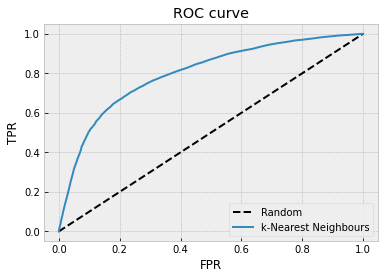


- optimal probability threshold:

0.49

- precision recall tradeoff:



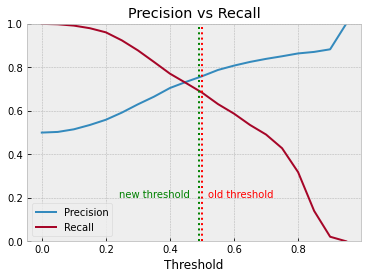


- performance metrics (new threshold):

accuracy = 0.733, auc_score = 0.733

precision = 0.754, recall = 0.693, f1-score = 0.722

- confusion matrix:



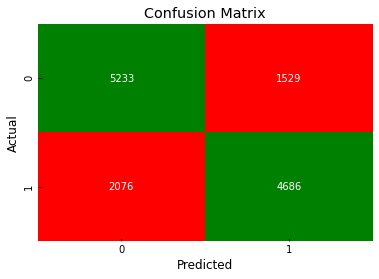

In [18]:
model_report(y_test, y_test_hat, y_test_proba, "k-Nearest Neighbours")

## Naive Bayes Classifier

### Categorical NB

#### Preprocessing Data

In [0]:
X_train_binned = data_preprocessor(X_train, bins = True)
X_test_binned = data_preprocessor(X_test, bins = True)

#### Training Model

In [0]:
nb = CategoricalNB()
cat_nb_model = nb.fit(X_train_binned, y_train)

y_test_hat = cat_nb_model.predict(X_test_binned)
y_test_proba = cat_nb_model.predict_proba(X_test_binned)[:,1]

#### Model Report

Categorical Naive Bayes Model Report


- performance metrics (default threshold):

accuracy = 0.72, auc_score = 0.72

precision = 0.754, recall = 0.654, f1-score = 0.7

- ROC curve:



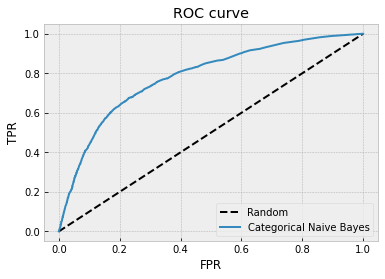


- optimal probability threshold:

0.36

- precision recall tradeoff:



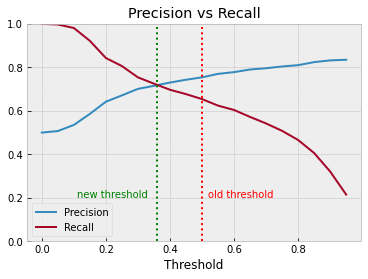


- performance metrics (new threshold):

accuracy = 0.719, auc_score = 0.719

precision = 0.721, recall = 0.714, f1-score = 0.717

- confusion matrix:



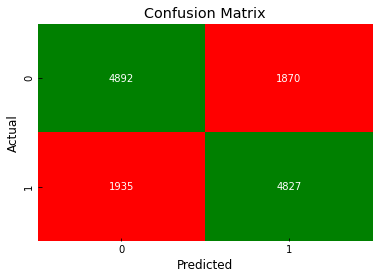

In [23]:
model_report(y_test, y_test_hat, y_test_proba, "Categorical Naive Bayes")

### Mixed NB

#### Training model

In [0]:
num_nb_model, cat_nb_model, mixed_nb_model = mixed_NB(X_train_scaled, y_train)
y_test_hat, y_test_proba = mixed_NB_predict(num_nb_model, cat_nb_model, mixed_nb_model, X_test_scaled)

#### Model Report

Mixed Naive Bayes Model Report


- performance metrics (default threshold):

accuracy = 0.717, auc_score = 0.717

precision = 0.779, recall = 0.607, f1-score = 0.682

- ROC curve:



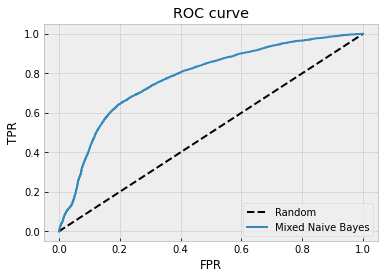


- optimal probability threshold:

0.35

- precision recall tradeoff:



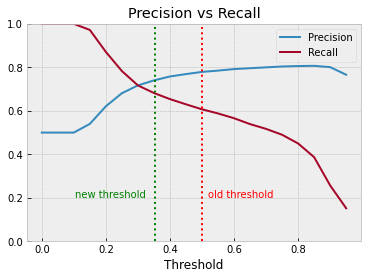


- performance metrics (new threshold):

accuracy = 0.722, auc_score = 0.722

precision = 0.741, recall = 0.682, f1-score = 0.71

- confusion matrix:



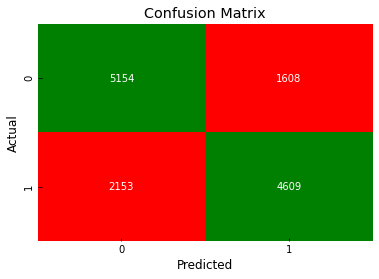

In [31]:
model_report(y_test, y_test_hat, y_test_proba, "Mixed Naive Bayes")